<a href="https://colab.research.google.com/github/cristovaor/Projeto/blob/main/Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install opencv-python

In [ ]:
# Importando Pacotens Necessários
import numpy as np
import pickle
import cv2
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
!pip install bayesian-optimization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Importando Keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.optimizers import Adam

In [ ]:
default_image_size = tuple((348, 348))
## Função para Converter imagem para Tupla 348 X 348

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Erro : {e}")
        return None

In [ ]:
# Conectando ao Drive para baixar o Dataset
from google.colab import drive
from google.colab import files

# Definindo Caminho
drive.mount('/content/drive')

Mounted at /content/drive


### Carregando Labels Encodados

In [ ]:
# Carregando dados de Classe 
colunas = ['Class','Class_ID','CoarseClassName','CoarseClassID','IconicImagePath','ProductDescriptionPath']
e_lables = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataset/classes.csv", names=colunas)
e_lables.drop(e_lables.index[:1], inplace=True)
e_lables

,Class,Class_ID,CoarseClassName,CoarseClassID,IconicImagePath,ProductDescriptionPath
1,Golden-Delicious,0,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Go...,/iconic-images-and-descriptions/Fruit/Apple/Go...
2,Granny-Smith,1,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Gr...,/iconic-images-and-descriptions/Fruit/Apple/Gr...
3,Pink-Lady,2,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Pi...,/iconic-images-and-descriptions/Fruit/Apple/Pi...
4,Red-Delicious,3,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Re...,/iconic-images-and-descriptions/Fruit/Apple/Re...
5,Royal-Gala,4,Apple,0,/iconic-images-and-descriptions/Fruit/Apple/Ro...,/iconic-images-and-descriptions/Fruit/Apple/Ro...
...,...,...,...,...,...,...
77,Red-Beet,76,Red-Beet,40,/iconic-images-and-descriptions/Vegetables/Red...,/iconic-images-and-descriptions/Vegetables/Red...
78,Beef-Tomato,77,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...
79,Regular-Tomato,78,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...
80,Vine-Tomato,79,Tomato,41,/iconic-images-and-descriptions/Vegetables/Tom...,/iconic-images-and-descriptions/Vegetables/Tom...


### Lendo imagens[image_list_a] e a label correspondente de lables[label_list]

In [ ]:
image_list_a, label_list = [], []

totalImage = 0  # Variavel para o Controle do Número Total de Imagens por Classe

root_dir = listdir("/content/drive/My Drive/Colab Notebooks/dataset/test") # Specify location of plant images

for image_folder in root_dir :  # Olhando para Cara Diretório
    # Olhando imagens pelo diretório
    
    image_list = listdir(f"/content/drive/My Drive/Colab Notebooks/dataset/test/{image_folder}")
    
    for image in image_list:
               
        image_sub_cat = listdir(f"/content/drive/My Drive/Colab Notebooks/dataset/test/{image_folder}/{image}")
     
        for image_sub_cat_name in image_sub_cat:
        
            #print(image_sub_cat_name)
            path  = f"/content/drive/My Drive/Colab Notebooks/dataset/test/{image_folder}/{image}/{image_sub_cat_name}"
            
            if os.path.isdir(path):  
                image_sub_cat_name_jpg = listdir(f"/content/drive/My Drive/Colab Notebooks/dataset/test/{image_folder}/{image}/{image_sub_cat_name}")
                
                for image_name in image_sub_cat_name_jpg:
                    #print(image_sub_cat_name)
                    #print(label_list.append(e_lables.loc[e_lables['Class'] == image_sub_cat_name].Class_ID.iloc[0]))
                    label_list.append(e_lables.loc[e_lables['Class'] == image_sub_cat_name].Class_ID.iloc[0])
                    if image_name.endswith(".jpg") == True or image_name.endswith(".JPG") == True:
                        image_full_path = f"/content/drive/My Drive/Colab Notebooks/dataset/test/{image_folder}/{image}/{image_sub_cat_name}/{image_name}"
                        image_list_a.append(convert_image_to_array(image_full_path))
                    
            if os.path.isfile(path):
                #print(image_sub_cat_name)
                label_list.append(e_lables.loc[e_lables['Class'] == image].Class_ID.iloc[0])
                
                if image_sub_cat_name.endswith(".jpg") == True or image_sub_cat_name.endswith(".JPG") == True:
                        image_full_path = f"/content/drive/My Drive/Colab Notebooks/dataset/test/{image_folder}/{image}/{image_sub_cat_name}"
                        image_list_a.append(convert_image_to_array(image_full_path))
            
# Convertendo images_list_a e lable_list para numpy array
image_list_a = np.asarray(image_list_a)
label_list = np.asarray(label_list)

### Total de 12 exemplos, cada uma com 348 X 348 e possuindo os 3 canais

(2485,) (2485, 348, 348, 3)


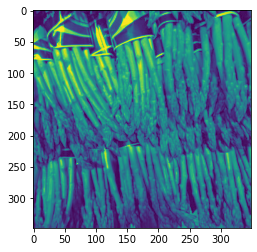

In [ ]:
# Exibindo Shape
print(label_list.shape, image_list_a.shape)

# Exibindo Primeira Imagem para Visulalização
plt.imshow(image_list_a[0][: ,: ,1])

In [ ]:
# Definindo Classes e Variaveis
n_classes = 81

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
# Dividindo dados em Treino e Teste
image_list_a = np.asarray(image_list_a)
x_train, x_test, y_train, y_test = train_test_split(image_list_a, label_list, test_size=0.2, random_state = 42)
y_train = tf.keras.utils.to_categorical(y_train, 81)
y_test = tf.keras.utils.to_categorical(y_test, 81)


In [ ]:
# Variaveis da Rede Neural
EPOCHS = 20
INIT_LR = 0.002
BS = 32
width=348
height=348
depth=3
inputShape = (height, width, depth)
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) 
chanDim = 1


def get_model(input_shape, dropout2_rate=0.5):
    model = Sequential()
    model.add(Conv2D(4, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(524))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2_rate))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    model.summary()
    
    return model
# Criando Modelo


In [ ]:
# Adicionando Otimizador Adam
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
# Defindindo Função 
print(x_test.shape, y_test.shape, x_train.shape, y_train.shape, inputShape, input_shape)

history = model.fit(x_train, y_train, batch_size=32,validation_data=(x_test, y_test), epochs=EPOCHS, verbose=1)

(746, 348, 348, 3) (746, 81) (1739, 348, 348, 3) (1739, 81) (348, 348, 3) (348, 348, 3)
Epoch 1/50
15/55 [=======>......................] - ETA: 1:12 - loss: 5.0685 - accuracy: 0.0382

KeyboardInterrupt: ignored

In [ ]:
print(history.history.keys())

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
# Otimizando Rede Neural via Otimização Baysiana
# Difinindo Funções
from functools import partial

input_shape = input_shape
verbose = 1

def fit_with(input_shape, verbose, dropout2_rate, lr):
  # Create the model using a specified hyperparameters.
  model = get_model(input_shape, dropout2_rate)
  # Train the model for a specified number of epochs.
  optimizer= Adam(lr = lr)
  model.compile(optimizer=optimizer, loss = 'mse', metrics = ['accuracy'])
  # Train the model with the train dataset.
  model.fit(x_train, y_train, batch_size=32,validation_data=(x_test, y_test), epochs = 5, validation_steps = 60000 // 32, steps_per_epoch = 60000 // 32, verbose = verbose)

  # Evaluate the model with the eval dataset.
  score = model.evaluate(y_test, steps = 10, verbose=1)
 
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  print('\n')
  # Return the accuracy.
  return score[1]

fit_with_partial = partial(fit_with, input_shape, verbose)


In [ ]:
from bayes_opt import BayesianOptimization

bounds = {'lr'           :(1e-4, 1e-2),
          'dropout2_rate':(0.05, 0.5),
          'batch_size'   :(1, 4.001),
          'num_filters'  :(1, 4.001),
          'kernel_size'  :(2, 4.001)}        

bounds_2 = {'dropout2_rate': (0.1, 0.5), 
            'lr'           : (1e-4, 1e-2)}

optimizer = BayesianOptimization(f = fit_with_partial, pbounds = bounds_2, verbose = 1, random_state = 1)
optimizer.maximize(init_points = 81, n_iter = 2)

for i, res in enumerate(optimizer.res):
 print('Iteration {}: \n\t{}'.format(i, res))
print(optimizer.max)



|   iter    |  target   | dropou... |    lr     |
-------------------------------------------------
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 348, 348, 4)       112       
_________________________________________________________________
activation_12 (Activation)   (None, 348, 348, 4)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 348, 348, 4)       1392      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 116, 116, 4)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 116, 116, 4)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 53824)             0         
____________________

ValueError: ignored